In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.notebook import tqdm
from typing import List
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

%matplotlib inline

# Hyper-parameters
EPOCHS = 10
BATCH_SIZE = 15
LEARNING_RATE = 0.001
NUM_CLASSES = 2
NUM_IMGS = 10

cpu


In [115]:
#NOTE: change to your path
imgs = os.listdir('/home/filnow/Desktop/data/train')
imgs_test = os.listdir('/home/filnow/Desktop/data/test')

train_imgs, val_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

class CatsDogsDataset(Dataset):
    def __init__(self, imgs, root_dir, transform=None):
        self.imgs = imgs
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.imgs[idx])
        image = Image.open(img_name)
        label =  0 if self.imgs[idx].split('.')[0] == 'cat' else 1

        if self.transform:
            image = self.transform(image)
        return image, label

#NOTE hard coded mean and std for imagenet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = CatsDogsDataset(train_imgs, '/home/filnow/Desktop/data/train', transform=transform_train)
val_dataset = CatsDogsDataset(val_imgs, '/home/filnow/Desktop/data/train', transform=transform_test)
test_dataset = CatsDogsDataset(imgs_test, '/home/filnow/Desktop/data/test', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

First row : ['cat', 'cat', 'dog', 'cat', 'cat'] 
Second row : ['dog', 'cat', 'dog', 'cat', 'dog']


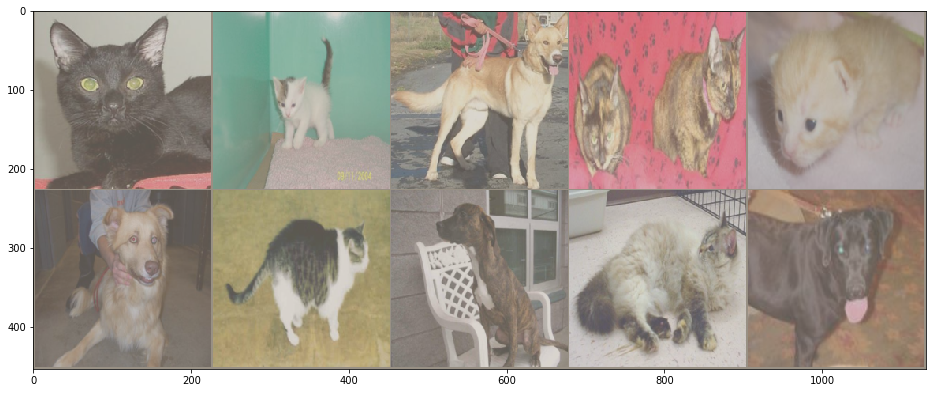

In [116]:
#Visualize some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = ((npimg * std) + mean) * 255
    plt.figure(figsize=(16,12))
    plt.imshow(npimg.astype(np.uint8), interpolation='nearest')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

true_labels = ['cat' if label == 0 else 'dog' for label in labels]
print(f'First row : {true_labels[:NUM_IMGS//2]} \nSecond row : {true_labels[NUM_IMGS//2:NUM_IMGS]}')
# show images
imshow(torchvision.utils.make_grid(images[:NUM_IMGS], nrow=NUM_IMGS//2))

In [1]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
model = torchvision.models.resnet18(pretrained=True)

set_parameter_requires_grad(model, True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model = model.to(device)

params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
optimizer = optim.Adam(params_to_update, lr = 1e-4, eps = 1e-6)
criterion = nn.CrossEntropyLoss()

total_step = len(train_loader)

for epoch in range(EPOCHS):
    model.train()

    for i, (images, labels) in tqdm(enumerate(train_loader), total=total_step, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Test the model
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            val_loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total

        print(f'For epoch {epoch+1}:\nVal_loss: {val_loss.item():.4f}\nLoss: {loss.item():.4f}\nAccuracy: {accuracy:.2f}% ')

In [ ]:
#Test on some images from test set
model.eval()
class_names = ['cat', 'dog']

with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    imshow(torchvision.utils.make_grid(images[:NUM_IMGS], nrow=NUM_IMGS//2))
    
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(NUM_IMGS)))